In [1]:
from statsmodels.tsa.seasonal import STL
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import SimpleExpSmoothing
from sklearn.cluster import DBSCAN
from sklearn.metrics import mean_squared_error
import os

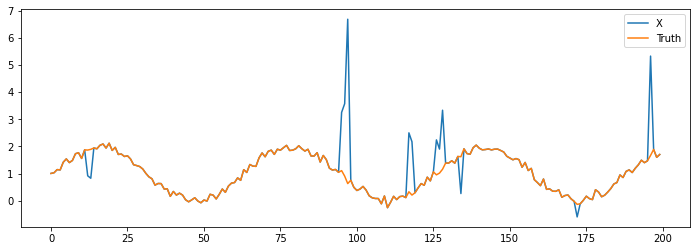

In [2]:
sample = pd.read_csv('../data/sample3.csv')
plt.figure(figsize=(12, 4))
sample[:200].plot(ax=plt.gca())
plt.show()

In [37]:
stl = STL(sample.X, period=21, seasonal=21)
decomposition = stl.fit()
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

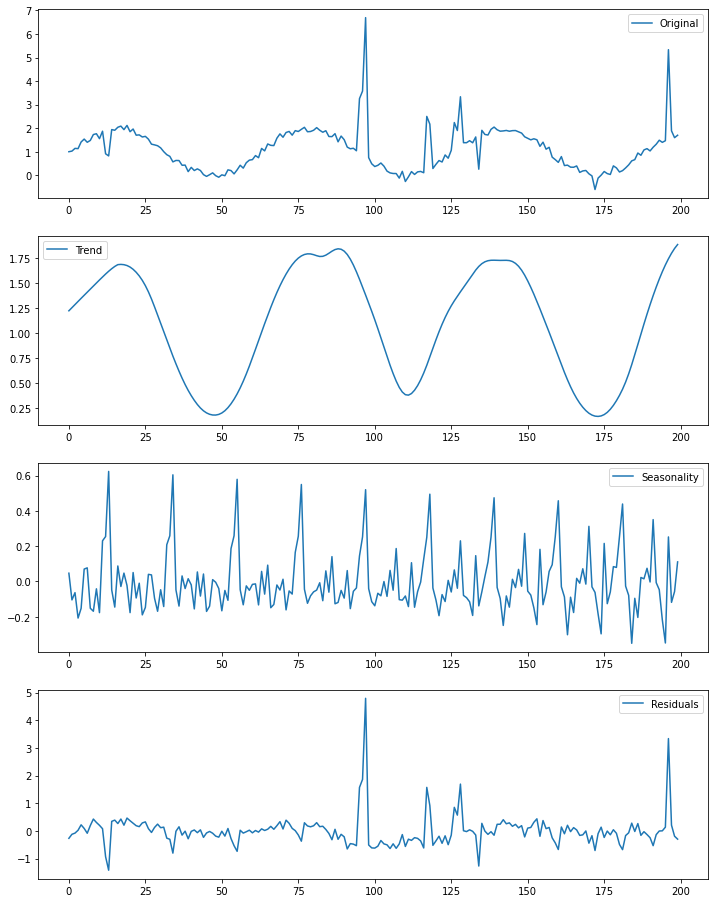

In [39]:
plt.figure(figsize=(12,16))
plt.subplot(411)
plt.plot(sample.X[:200], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend[:200], label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal[:200],label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual[:200], label='Residuals')
plt.legend(loc='best')
plt.show()

In [57]:
def clean(X):
    
    n = 1000 # number of observations for fitting
    X_clean = X.copy()
    
    for i in range(3):
    
        # calculate diff
        stl = STL(X_clean, period=21, seasonal=21)
        decomposition = stl.fit()

        X_diff = decomposition.resid.copy()
        X_diff = pd.Series(X_diff).fillna(0).values
        X_diff = X_diff / np.linalg.norm(X_diff)
        X_diff = np.reshape(X_diff, (X_diff.shape[0], 1))

        # fit eps
        eps_space = np.linspace(0.00001, 0.00025, 100)
        cluster_size = []
        for eps in eps_space:
            dbscan = DBSCAN(eps=eps).fit(X_diff[:n])
            largest_size = 0
            for label in set(dbscan.labels_):
                len_set = (dbscan.labels_ == label).sum()
                if largest_size < len_set:
                    largest_size = len_set
            cluster_size.append(largest_size / n * 100)
        cluster_size = np.array(cluster_size)
        best_eps = eps_space[np.argmax(cluster_size[1:] - cluster_size[:-1]) + 1]

        # clustering
        dbscan = DBSCAN(eps=best_eps).fit(X_diff)

        # updating
        largest_size = 0
        largest_cluster = None
        for label in set(dbscan.labels_):
            len_set = (dbscan.labels_ == label).sum()
            if largest_size < len_set:
                largest_size = len_set
                largest_cluster = label

        X_clean[dbscan.labels_ != largest_cluster] = None
        X_clean = pd.Series(X_clean).interpolate().values
        X_clean = pd.Series(X_clean).fillna(0).values

    return X_clean

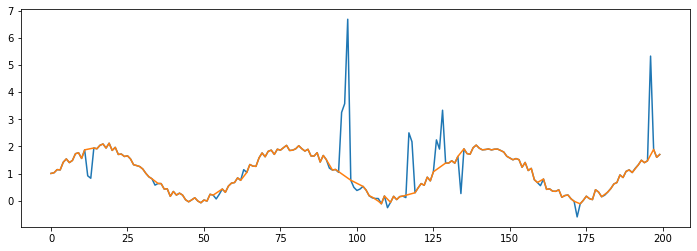

In [58]:
plt.figure(figsize=(12,4))
plt.plot(sample.X[:200])
plt.plot(clean(sample.X)[:200])

In [59]:
def get_files_list(path):
    files = []
    for aname in os.listdir(path):
        if (aname[-3:] == "csv") or (aname[-3:] == "txt"): 
            files.append(os.path.join(path, aname))
    return files

def run_tests(dir_path):
    
    print("Dataset: ", dir_path)
    files = get_files_list(dir_path)
    files.sort()
    
    report = pd.DataFrame(columns=["Sample", "RMSE"])
    
    for afile in files:
        
        print("File: ", afile)
            
        data = pd.read_csv(afile, index_col=False)
        
        X      = data['X'].values
        X_true = data['Truth'].values
        
        X_clean = clean(X)
        
        rmse = mean_squared_error(X_true, X_clean, squared=False)
        
        report.loc[len(report)] = [afile, rmse]
        print("RMSE: ", rmse)
            
    return report

In [60]:
report = run_tests('../data/')
report

Dataset:  ../data/
File:  ../data/sample1.csv
RMSE:  0.15512529014250703
File:  ../data/sample2.csv
RMSE:  0.11026886803786842
File:  ../data/sample3.csv
RMSE:  0.17661527102343813
File:  ../data/sample4.csv
RMSE:  0.17889960583371292
File:  ../data/sample5.csv
RMSE:  0.16137038235914725
File:  ../data/sample6.csv
RMSE:  2.8571642939033164
File:  ../data/sample7.csv
RMSE:  6.2575939101778255
File:  ../data/sample8.csv
RMSE:  0.7369940585831763
File:  ../data/sample9.csv
RMSE:  82.34195519765929


Sample       RMSE
0  ../data/sample1.csv   0.155125
1  ../data/sample2.csv   0.110269
2  ../data/sample3.csv   0.176615
3  ../data/sample4.csv   0.178900
4  ../data/sample5.csv   0.161370
5  ../data/sample6.csv   2.857164
6  ../data/sample7.csv   6.257594
7  ../data/sample8.csv   0.736994
8  ../data/sample9.csv  82.341955

In [61]:
board = pd.DataFrame(columns=['Data preparation', 'Model']+['sample'+str(i) for i in range(1, 10)])
board.loc[len(board)] = ['STL decomposition', 'DBSCAN'] + list(report['RMSE'].values)
board = board.set_index(['Data preparation', 'Model'])
board

sample1   sample2   sample3  sample4  sample5  \
Data preparation  Model                                                    
STL decomposition DBSCAN  0.155125  0.110269  0.176615   0.1789  0.16137   

                           sample6   sample7   sample8    sample9  
Data preparation  Model                                            
STL decomposition DBSCAN  2.857164  6.257594  0.736994  82.341955

In [62]:
board.iloc[[0], :].to_csv('../results/stl_dec_dbscan.csv')